In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [114]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
import fbpca

from libertem import api
from libertem.udf.pca_data import run_pca

In [4]:
def diffsnorm(data, reconstruct):
    return math.sqrt(norm(data-reconstruct))


In [5]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [6]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [124]:
component = ortho_group.rvs(dim=1024)
loading = np.identity(1024)

data = loading @ component
data.shape

(1024, 1024)

In [65]:
# orthogonality of component vectors
component[:, 0].dot(component[:, 1])

-1.5612511283791264e-17

In [118]:
noise_data = np.random.rand(1024, 1024)

In [125]:
for n_component in range(100, 1100, 100):
    U, S, V = fbpca.pca(data, k=n_component)
    reconstructed_data = (data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 100 components using full batch data: 5.5133808418375505
norm difference wih 200 components using full batch data: 5.35774207934785
norm difference wih 300 components using full batch data: 5.187219688247973
norm difference wih 400 components using full batch data: 4.997998798878767
norm difference wih 500 components using full batch data: 4.784458828803858
norm difference wih 600 components using full batch data: 4.537759390048572
norm difference wih 700 components using full batch data: 4.242640687119285
norm difference wih 800 components using full batch data: 3.8686728405353406
norm difference wih 900 components using full batch data: 3.336993965481493
norm difference wih 1000 components using full batch data: 2.2133638394006234


In [123]:
for n_component in range(100, 1100, 100):
    U, S, V = fbpca.pca(noise_data, k=n_component)
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 100 components using full batch data: 23.332855198736066
norm difference wih 200 components using full batch data: 22.437657007521064
norm difference wih 300 components using full batch data: 21.524211544610655
norm difference wih 400 components using full batch data: 20.73591251726742
norm difference wih 500 components using full batch data: 19.655820606799164
norm difference wih 600 components using full batch data: 18.471262491891718
norm difference wih 700 components using full batch data: 17.11969558214331
norm difference wih 800 components using full batch data: 15.551645453672535
norm difference wih 900 components using full batch data: 13.644034278350658
norm difference wih 1000 components using full batch data: 9.097632638356947


In [126]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [127]:
# reformat data into sig and nav dimension
data = data.reshape((32, 32, 32, 32))

In [128]:
def process_partition(data, n_components=100):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    for i in range(2):
        for j in range(2):
            part = data[i*16:i*16+16, j*16:j*16+16, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = fbpca.pca(part_reshape, k=n_components)
            
            partition.append((U, S, V, part_reshape[0]))
    
    return partition


In [109]:
def merge(data, partition, n_components=100):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((1024, 1024))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [115]:
start = time.time()

partition = process_partition(data) # generate partitions and run PCA on them
data_transformed, reconstructed_data = merge(data, partition) # merge partitions

end = time.time()

print(f"Takes {end-start} sec")

Takes 1.2645699977874756 sec


In [116]:
orig_data = data.reshape((1024, 1024))
diffsnorm(reconstructed_data, orig_data)

49.44601289607006

In [113]:
data_transformed.shape # transformed data

(1024, 100)

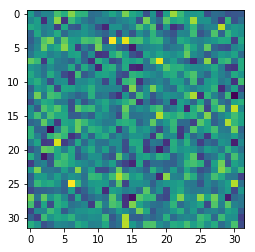

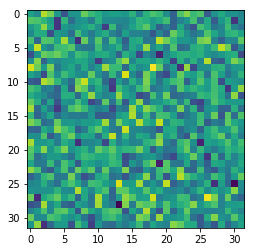

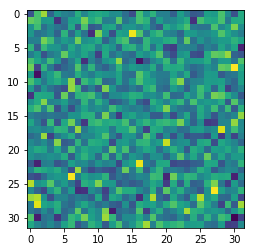

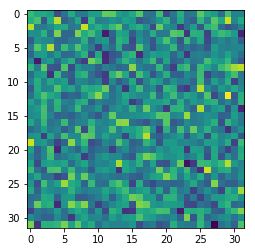

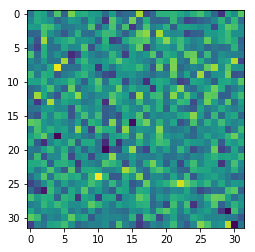

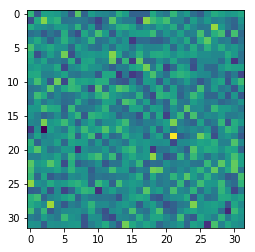

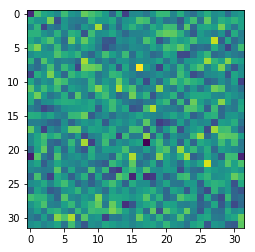

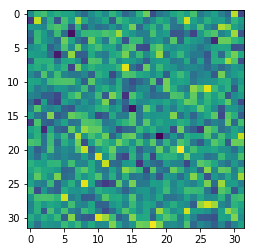

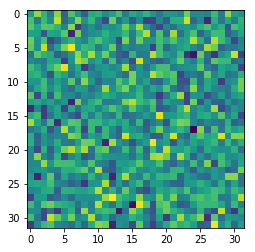

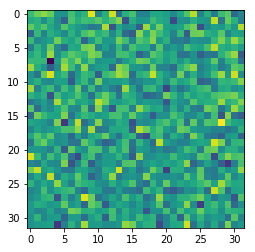

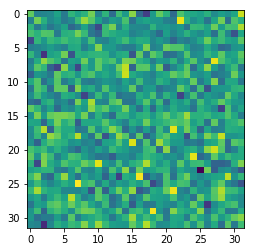

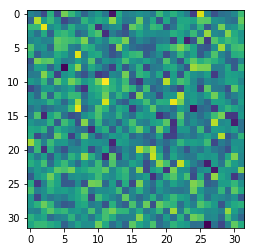

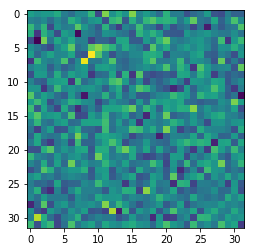

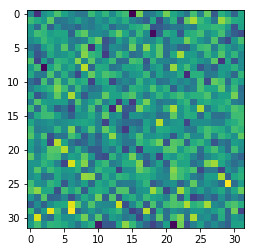

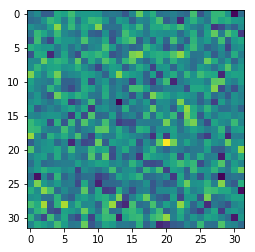

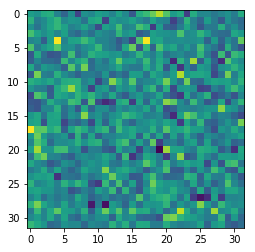

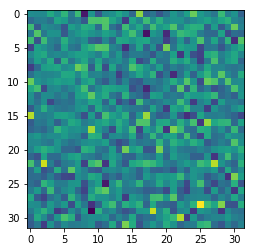

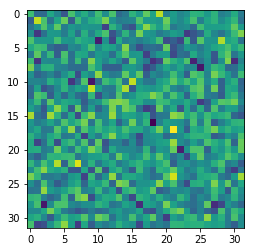

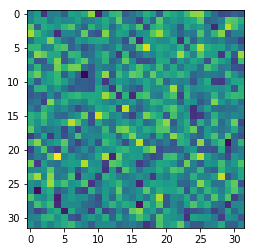

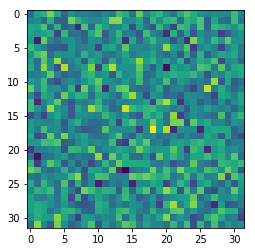

In [117]:
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))
    
    f, axes = plt.subplots()
    axes.imshow(vis)